## Neural Stylization with Pytorch

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image
import numpy as np

from torchvision import datasets

from torch.utils.data import DataLoader


**Style and content image**

In [3]:
style_img_name = "dataset/lab10/style/mosaic.jpg"
content_img_name = "dataset/lab10/content/Tuebingen_Neckarfront.jpg"

In [4]:
style_img = Image.open(style_img_name)
content_img = Image.open(content_img_name)

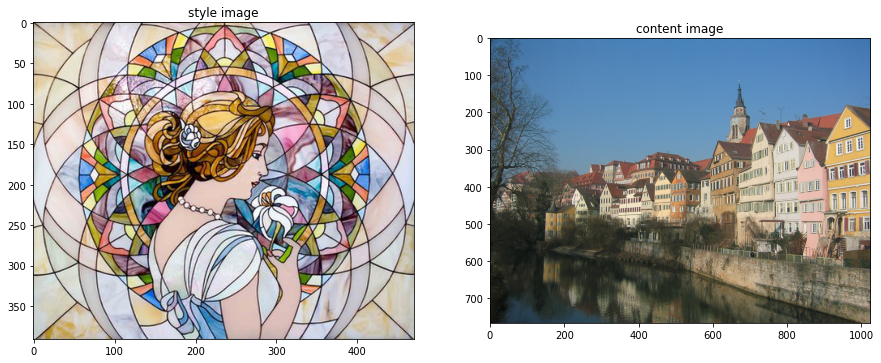

In [5]:
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.title('style image')
plt.imshow(style_img)
plt.subplot(1,2,2)
plt.title('content image')
plt.imshow(content_img)

### Gram matrix

In [6]:
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

In [7]:
import torchvision.models.vgg as vgg

class LossNetwork(torch.nn.Module):
    def __init__(self):
        super(LossNetwork, self).__init__()
        # get vgg network
        self.vgg_layers = vgg.vgg19(pretrained=True).features


    def forward(self, x, layer_name):
        output = {}
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in layer_name:
                output[layer_name[name]] = x
        return output

In [8]:
loss_net = LossNetwork().cuda()
for param in loss_net.parameters():
    param.requires_grad = False

In [9]:
style_layer_name = {
    '1': "conv1-1",
    '6': "conv2-1",
    '11': "conv3-1",
    '20': "conv4-1",
    '29': "conv5-1"
}

content_layer_name = {
    '22': "conv4-2"
}

**Pre and post processing for images**

In [10]:
img_size = 512 
prep = transforms.Compose([transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                        std=[1,1,1]),
])

post = transforms.Compose([
    transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                        std=[1,1,1]),
    transforms.Lambda(lambda x: torch.clamp(x,0,1)),
    transforms.ToPILImage()
])

In [11]:
content = prep(content_img).cuda().unsqueeze(0)
style = prep(style_img).cuda().unsqueeze(0)

out_img = content.clone()
out_img.requires_grad = True


criterion = nn.MSELoss()
style_gt = [gram_matrix(f).detach() for f in loss_net(style, style_layer_name).values()]
content_gt = [A.detach() for A in loss_net(content, content_layer_name).values()]

show_iter = 50
optimizer = optim.LBFGS([out_img])
n_iter = [0]

**Hyper parameters**

In [12]:
alpha = 1e0
beta = 1e7
max_iter = 500

**Optimizing image**

In [13]:
while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        
        style_layers = [gram_matrix(f) for f in loss_net(out_img, style_layer_name).values()]
        content_layers = [f for f in loss_net(out_img, content_layer_name).values()]
        
        style_loss = 0
        for i in range(len(style_layers)):    
            style_loss += criterion(style_layers[i], style_gt[i])
        
        content_loss = criterion(content_layers[0], content_gt[0])
        
        loss = alpha * content_loss + beta * style_loss
        loss.backward()
        n_iter[0]+=1
    
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))

        return loss

    optimizer.step(closure)
    
#display result

Iteration: 50, loss: 9.043251
Iteration: 100, loss: 6.485054
Iteration: 150, loss: 5.743600
Iteration: 200, loss: 5.384400
Iteration: 250, loss: 5.178093
Iteration: 300, loss: 5.042357
Iteration: 350, loss: 4.951034
Iteration: 400, loss: 4.880187
Iteration: 450, loss: 4.826825
Iteration: 500, loss: 4.785725


**Visualize result images**

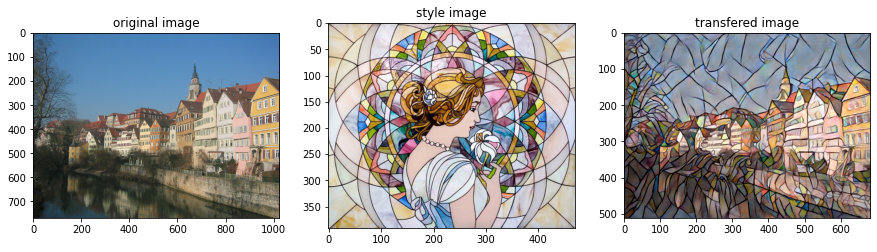

In [14]:
out_img_hr = post(out_img.data[0].cpu().squeeze())

plt.figure(figsize = (15,15))

plt.subplot(1,3,1)
plt.title('original image')
plt.imshow(content_img)
plt.subplot(1,3,2)
plt.title('style image')
plt.imshow(style_img)
plt.subplot(1,3,3)
plt.title('transfered image')
plt.imshow(out_img_hr)
plt.show()

## Perceptual Losses for Style Transfer with Pytorch

**Data loader**

In [15]:
data_root = "dataset/lab10/train"
image_size = 224
transform = transforms.Compose([
    transforms.Resize(image_size), 
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder(data_root, transform)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### Image Transform Net Architecture

In [16]:
class ImageTransformNet(torch.nn.Module):
    def __init__(self):
        super(ImageTransformNet, self).__init__()
        self.features = nn.Sequential(
                        nn.Conv2d(3, 32, 9, padding=4, padding_mode='reflect'),
                        nn.InstanceNorm2d(32, affine=True),
                        nn.ReLU(),
                        nn.Conv2d(32, 64, 3, padding=1, stride=2, padding_mode='reflect'),
                        nn.InstanceNorm2d(64, affine=True),
                        nn.ReLU(),
                        nn.Conv2d(64, 128, 3, padding=1, stride=2, padding_mode='reflect'),
                        nn.InstanceNorm2d(128, affine=True),
                        nn.ReLU()
        )
        self.block1 = nn.Sequential(
                        nn.Conv2d(128, 128, 3, padding=1, padding_mode='reflect'),
                        nn.InstanceNorm2d(128, affine=True),
                        nn.ReLU(),
                        nn.Conv2d(128, 128, 3, padding=1, padding_mode='reflect'),
                        nn.InstanceNorm2d(128, affine=True)
        )
        self.block2 = nn.Sequential(
                        nn.Conv2d(128, 128, 3, padding=1, padding_mode='reflect'),
                        nn.InstanceNorm2d(128, affine=True),
                        nn.ReLU(),
                        nn.Conv2d(128, 128, 3, padding=1, padding_mode='reflect'),
                        nn.InstanceNorm2d(128, affine=True)
        )
        self.block3 = nn.Sequential(
                        nn.Conv2d(128, 128, 3, padding=1, padding_mode='reflect'),
                        nn.InstanceNorm2d(128, affine=True),
                        nn.ReLU(),
                        nn.Conv2d(128, 128, 3, padding=1, padding_mode='reflect'),
                        nn.InstanceNorm2d(128, affine=True)
        )
        self.block4 = nn.Sequential(
                        nn.Conv2d(128, 128, 3, padding=1, padding_mode='reflect'),
                        nn.InstanceNorm2d(128, affine=True),
                        nn.ReLU(),
                        nn.Conv2d(128, 128, 3, padding=1, padding_mode='reflect'),
                        nn.InstanceNorm2d(128, affine=True)
        )
        self.block5 = nn.Sequential(
                        nn.Conv2d(128, 128, 3, padding=1, padding_mode='reflect'),
                        nn.InstanceNorm2d(128, affine=True),
                        nn.ReLU(),
                        nn.Conv2d(128, 128, 3, padding=1, padding_mode='reflect'),
                        nn.InstanceNorm2d(128, affine=True)
        )
        self.upconv = nn.Sequential(
                        nn.Upsample(scale_factor=2, mode='nearest'),
                        nn.Conv2d(128, 64, 3, padding=1, padding_mode='reflect'),
                        nn.InstanceNorm2d(64, affine=True),
                        nn.ReLU(),
                        nn.Upsample(scale_factor=2, mode='nearest'),
                        nn.Conv2d(64, 32, 3, padding=1, padding_mode='reflect'),
                        nn.InstanceNorm2d(32, affine=True),
                        nn.ReLU(),
                        nn.Conv2d(32, 3, 9,padding=4, padding_mode='reflect')
        )
        

    def forward(self, X):
        out = self.features(X)
        out = F.relu(out + self.block1(out)) 
        out = F.relu(out + self.block2(out))
        out = F.relu(out + self.block3(out))
        out = F.relu(out + self.block4(out))
        out = F.relu(out + self.block5(out))
        out = self.upconv(out)
        
        return out


In [17]:
transformer = ImageTransformNet().cuda()

### Style and content representation layers in loss net

In [18]:
style_layer_name = {
    '3': 'relu1_2',
    '8': 'relu2_2',
    '15': 'relu3_3',
    '24': 'relu4_3'
}

content_layer_name = {
    '8': 'relu2_2'
}

In [19]:
style = transform(style_img).cuda().unsqueeze(0)
style_gt = [gram_matrix(f).detach() for f in loss_net(style, style_layer_name).values()]

**Hyper parameters**

In [20]:
alpha = 1e0
beta = 1e4
gamma = 1e-7

LR = 1e-3
steps = 2000
optimizer = optim.Adam(transformer.parameters(), LR)

### Train the image transformNet 

In [21]:
transformer.train()
n_iter = 0
class Found(Exception): pass
try:
    while True:
        for x, _ in train_loader:
            optimizer.zero_grad()
            x = x.cuda()
            
            y_hat = transformer(x)
            y_hat_gt = [gram_matrix(f) for f in loss_net(y_hat, style_layer_name).values()]
 
            style_loss = 0.0
            
            for k in range(len(x)):
                style_loss += criterion(y_hat_gt[k], style_gt[k])
                
            style_loss = beta * style_loss
            
            y_content_net = [f.detach() for f in loss_net(x, content_layer_name).values()]
            y_hat_net = [f for f in loss_net(y_hat, content_layer_name).values()]
            content_loss = alpha * criterion(y_hat_net[0] , y_content_net[0])
            
            diff_i = torch.sum(torch.abs(y_hat[:, :, :, 1:] - y_hat[:, :, :, :-1]))
            diff_j = torch.sum(torch.abs(y_hat[:, :, 1:, :] - y_hat[:, :, :-1, :]))
            tv_loss = gamma * (diff_i + diff_j)
            

            total_loss = content_loss + style_loss + tv_loss
            n_iter += 1
            
            total_loss.backward()
            optimizer.step()
            
            if n_iter % 50 == 0:
                print("total loss: {:.3f} content loss: {:.3f} style loss: {:.3f} total variation loss {:.3f}".format(total_loss,content_loss,style_loss,tv_loss))
            
            if n_iter >= steps:
                raise Found
        transformer.eval()

except Found:
    pass
    

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1, 64, 64])) that is different to the input size (torch.Size([4, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1, 128, 128])) that is different to the input size (torch.Size([4, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1, 256, 256])) that is different to the input size (torch.Size([4, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the

total loss: 24.679 content loss: 12.859 style loss: 11.787 total variation loss 0.032
total loss: 19.521 content loss: 12.623 style loss: 6.862 total variation loss 0.037
total loss: 16.732 content loss: 11.190 style loss: 5.502 total variation loss 0.040
total loss: 16.092 content loss: 11.691 style loss: 4.360 total variation loss 0.042
total loss: 14.473 content loss: 10.359 style loss: 4.074 total variation loss 0.041
total loss: 14.129 content loss: 10.587 style loss: 3.501 total variation loss 0.042
total loss: 13.258 content loss: 10.121 style loss: 3.095 total variation loss 0.043
total loss: 13.486 content loss: 10.317 style loss: 3.127 total variation loss 0.043
total loss: 13.276 content loss: 9.899 style loss: 3.333 total variation loss 0.044
total loss: 12.496 content loss: 9.184 style loss: 3.270 total variation loss 0.042
total loss: 12.814 content loss: 9.743 style loss: 3.028 total variation loss 0.043
total loss: 12.353 content loss: 8.651 style loss: 3.663 total vari

### Visualization

In [22]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])])

inverse_transform = transforms.Compose([
    transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
                         std=[1/0.229, 1/0.224, 1/0.255]),
    transforms.Lambda(lambda x: torch.clamp(x,0,1)),
    transforms.ToPILImage()
])

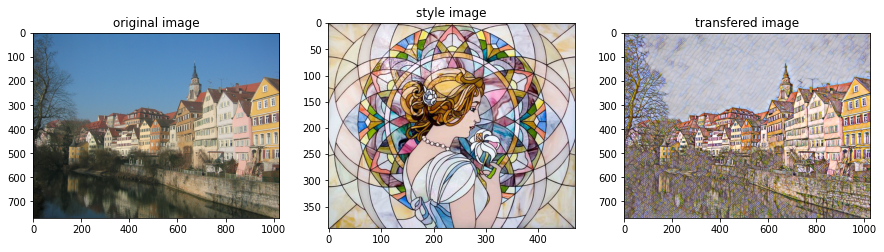

In [23]:
content_img = Image.open(content_img_name)
content = test_transform(content_img).cuda().unsqueeze(0)
out_img = content.clone()
out_img.requires_grad = True

out_img = transformer(out_img)
out_img_hr = inverse_transform(out_img.data[0].cpu().squeeze())

plt.figure(figsize = (15,15))

plt.subplot(1,3,1)
plt.title('original image')
plt.imshow(content_img)
plt.subplot(1,3,2)
plt.title('style image')
plt.imshow(style_img)
plt.subplot(1,3,3)
plt.title('transfered image')
plt.imshow(out_img_hr)
plt.show()

### *References*
[1] Neural Transfer Pytorch Tutorial (https://pytorch.org/tutorials/advanced/neural_style_tutorial.html)